## Introduction
In this notebook, I provide an analysis for food assistance efforts in Central PA. In particular, I look at how food agencies, e.g. soup kitchens and local food banks, are spread over the 27 counties of Central PA (the service area of the Central Pennsylvania Food Bank). In addition to spatial analysis, I also look at whether there are patterns between the presence of a food agency and the demographics of local communities. I use block groups as the geographic units of analysis.

## Data:
1. **Block groups dataset (source: [American FactFinder](https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml)):**  
a. **geoid**: block group id  
b. **aland**: area of land (non-water) in square meter  
c. **awater**: area of water surfaces  
d. **income**: average per capita income ($)  
e. **population**: number of people  
f. **kmdensity**: population density per squared kilometer (people/sq km)  
g. **centx**: x coordinate of block group centroid (longitude)  
h. **centy**: y coordinate of block group centroid (latitude)  


2. **Agencies dataset (source: Central PA Food Bank)**:   
a. **AgencyRef**: agency id  
b. **AgencyName**: name of agency  
c. **County**: county where the agency is located  
d. **Addr1**: stree address of agency  
e. **City**: city where the agency is located  
f. **State**: state where the agency is located  
g. **AgencyType**: type of agency  
h. **lat**: latitude of agency  
i. **lon**: longitude of agency  

## Import data and necessary packages 

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
from math import sin, cos, sqrt, atan2, radians
import numpy as np
%matplotlib inline

In [2]:
# block groups data
block_groups = pd.read_csv('block_groups_data.csv', index_col='geoid')
# agencies data
agencies = pd.read_csv('agency_data.csv', index_col='AgencyRef')

In [3]:
block_groups.head(3)

,aland,awater,income,population,kmdensity,centx,centy
geoid,,,,,,,
420130110012,23519032,13214,22944,846,35.970901,-78.498430,40.448109
420130105001,27698847,29740,23042,715,25.813299,-78.439655,40.559719
420130115002,18645960,0,19971,1269,68.057602,-78.467734,40.347121


In [4]:
agencies.head(3)

,AgencyName,County,Addr1,City,State,AgencyType,lat,lon
AgencyRef,,,,,,,,
11050,BETHLEHEM STONEPILE UMC,York,250 BETHLEHEM CHURCH ROAD,RED LION,PA,Church Pantry - Agency,39.894004,-76.570890
40036,SON LIGHT HOUSE,Lycoming,130 CARPENTER STREET,MUNCY,PA,Non-church Pantry - Agency,41.205642,-76.780767
40043,WELLSBORO AREA FOOD PANTRY,Tioga,36 MAIN STREET,WELLSBORO,PA,Non-church Pantry - Agency,41.749703,-77.300036


In [5]:
print('Number of block groups in Central PA: ', len(block_groups))
print('Number of food agencies in Central PA: ', len(agencies))

Number of block groups in Central PA:  2166
Number of food agencies in Central PA:  1014


In [6]:
# summary stats for block groups
block_groups[['income', 'population', 'kmdensity']].describe()

,income,population,kmdensity
count,2166.000000,2166.000000,2166.000000
mean,26675.701754,1394.739612,1168.259906
std,9074.516922,692.367101,2151.037648
min,1968.000000,31.000000,0.755881
25%,21495.750000,906.000000,58.849299
50%,25716.500000,1238.000000,407.280991
75%,31122.750000,1702.000000,1393.129974
max,88762.000000,5512.000000,35542.800780


In [7]:
# check if there is missing data in the block groups dataset
print('Number of missing values in the block groups data: ', block_groups.isnull().sum().sum())

Number of missing values in the block groups data:  0


In [8]:
# check if there is missing data in the agencies dataset
print('Number of missing values in the agencies data: ', agencies.isnull().sum().sum())

Number of missing values in the agencies data:  4


In [9]:
# check which columns of the agencies data have missing values
agencies.isnull().sum()

AgencyName    0
County        0
Addr1         2
City          0
State         0
AgencyType    0
lat           1
lon           1
dtype: int64

In [10]:
# remove rows that have missing data in lat and lon columns since I'm only interestied 
# in these columns
agencies.dropna(subset=['lat', 'lon'], inplace=True)
agencies.isnull().sum()

AgencyName    0
County        0
Addr1         2
City          0
State         0
AgencyType    0
lat           0
lon           0
dtype: int64

## Distance to nearest agency
Here I compute the distance between the centroid of a block group and the nearest agency to it. I use air distance (aka bird fly distance) because block groups are small enough such that using this distance instead of street distance won't be an over-simplification. I use the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) to calculate the [Great-Circle Distance](https://en.wikipedia.org/wiki/Great-circle_distance) to account for the spheric shape of Earth. Distance is then added to the block groups dataset.

In [11]:
# define distance function (gives distance between lon/lat points in miles)

def distance_in_miles(la1, lo1, la2, lo2):
    '''
    Calculates the distance between two GPS points.
    Inputs: la1/lo1: latitude and longitude of point 1, respectively
            la2/lo2: latitude and longitude of point 2, respectively
    Output: distance (miles) between the two points
    '''
    # approximate radius of earth in km
    R = 6373.0
    
    lat1 = radians(la1)
    lon1 = radians(lo1)
    lat2 = radians(la2)
    lon2 = radians(lo2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # compute distance in miles
    distance = R * c * 0.6213712
    return distance

In [12]:
# calculate distances between block groups and agencies

min_distances = []

for idx1, row1 in block_groups.iterrows():
    block_lat = row1['centy']
    block_lon = row1['centx']
    distances = []
    for idx2, row2 in agencies.iterrows():
        agency_lat = row2['lat']
        agency_lon = row2['lon']
        distances.append(distance_in_miles(block_lat, block_lon, agency_lat, agency_lon))
    min_distances.append(min(distances))

# add the min_distances list to the block groups data as a column
distances = pd.Series(min_distances)
block_groups['distance'] = distances.values

In [13]:
block_groups.head()

,aland,awater,income,population,kmdensity,centx,centy,distance
geoid,,,,,,,,
420130110012,23519032,13214,22944,846,35.970901,-78.498430,40.448109,1.935046
420130105001,27698847,29740,23042,715,25.813299,-78.439655,40.559719,3.316552
420130115002,18645960,0,19971,1269,68.057602,-78.467734,40.347121,2.352564
420130110022,3256834,0,32679,916,281.255005,-78.434047,40.463483,0.216430
420131016001,192907,0,11603,1131,5862.930176,-78.390637,40.514157,0.503062


### Do agencies tend to be in low-income areas?

In the literature, there are two competing hypotheses explaining the demand for food assistance. The first hypothesis is called the responsive community hypothesis, which states that areas with higher levels of poverty have less food assistance demands because the need in those areas is more apparent and local communities will respond to those needs by opening more food agencies, which results in less unsatisfied food demand. On the contrary, the second hypothesis states that those areas with higher levels of poverty have higher unsatisfied food demands due to lack of economic resources in those areas. The lack of resources hinders the opening of food agencies, which results in higher unsatisfied food demands. 

Below, I try to see if low-income areas tend to have nearby agencies by looking at the relationship between the average income of a block group and the distance to its nearest agency.

**Note:** I only look at whether an agency is present or not. For a complete analysis, one has to look at the amount of food received by an agency as well.

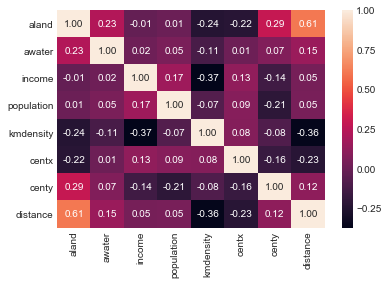

In [14]:
# first, check correlation matrix
sb.heatmap(block_groups.corr(), annot=True, fmt='0.2f');

#### Judging from the correlation matrix:
Distance seems to be correlated with the area of land and the population density. The larger the area, the longer the distance to an agency. This gives an indication that agencies tend to be more common in urban areas. This is consistent with the negative correlation with population density, which means the higher the density the shorter the distance to an agency.

There seems to be no correlation between distance and income. Correlation coefficient, however, only depicts **linear** relationships. Therefore, when the correlation coefficient between two variables is zero, this means there is no linear relationship between them. But, there could still be a relationship of higher orders, i.e. non-linear.

### Income vs. Distance
Below is a heatmap, or 2-dimensional histogram, between income and distance. Color indicates frequency of a certain pair of values. The hotter, the more frequent. 

Income axis is divided into $2,000 increments; distance is divided into 0.5 miles increments.

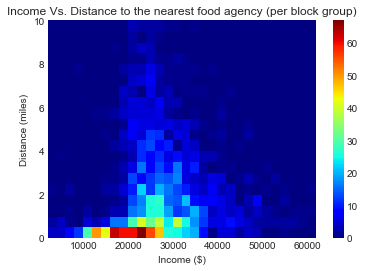

In [15]:
# bins sizes
bins_x = np.arange(block_groups['income'].min(), 60000+2000, 2000)
bins_y = np.arange(block_groups['distance'].min(), 10+0.5, 0.5)

plt.hist2d(block_groups['income'], block_groups['distance'], bins= [bins_x, bins_y],
           cmap='jet');
plt.colorbar();
plt.xlabel('Income ($)');
plt.ylabel('Distance (miles)');
plt.title('Income Vs. Distance to the nearest food agency (per block group)');

Agencies do seem to have a tendency towards lower income block groups.

### Identifying Under-served Areas
One of the objectives of the Central PA Food Bank is to identify under-served areas (or over-served areas). An under-served area is one where an agency is needed but there isn't one. Also, an under-served area could be one that does have an agency present, but it's not getting enough food assistance. However, I only look at the existence of an agency, or lack thereof, because food distribution data is not available.

Given the large number of block groups, it's difficult to pinpoint the ones that are under-served (if they exist) individually. Instead, it's easier to cluster similar block groups together. Then, identify the clusters that are in the most need for food assistance (perhaps those with lower income and longer distances). This way, the food bank can prioritize their distribution efforts more efficiently by targeting those clusters. 

#### Feature scaling
Block groups data have features with different scales. It's important to scale the data to avoid having one feature dominate the clustering process.

In [16]:
# selecting the features that will be used for clustering block groups
data = block_groups[['income', 'kmdensity', 'distance']]
data.head()

,income,kmdensity,distance
geoid,,,
420130110012,22944,35.970901,1.935046
420130105001,23042,25.813299,3.316552
420130115002,19971,68.057602,2.352564
420130110022,32679,281.255005,0.216430
420131016001,11603,5862.930176,0.503062


In [17]:
# import standard scaler from sklearn
from sklearn.preprocessing import StandardScaler
# define a scaler
scaler = StandardScaler()
# scaling the data
data_scaled = scaler.fit_transform(data)
# create a dataframe for the scaled data
df_scaled = pd.DataFrame(data_scaled)
df_scaled.columns = data.columns
df_scaled.head()

c:\python371\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python371\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,income,kmdensity,distance
0,-0.411324,-0.526514,-0.078179
1,-0.400522,-0.531237,0.500308
2,-0.739020,-0.511593,0.096651
3,0.661708,-0.412457,-0.797827
4,-1.661376,2.183018,-0.677804


In [18]:
from sklearn.cluster import KMeans

def get_kmeans_score(data, centers):
    '''
    Returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=centers)

    # Then fit the model to data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

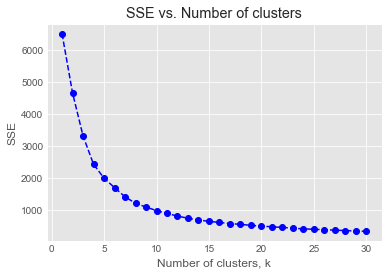

In [19]:
# determining the appropriate number of clusters using the elbow method

scores = []
centers = list(range(1, 31))

for center in centers:
    scores.append(get_kmeans_score(df_scaled, center))

plt.style.use('ggplot')
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Number of clusters, k');
plt.ylabel('SSE');
plt.title('SSE vs. Number of clusters');

10 seems to be the "elbow", since the reduction in SSE is insignificant when k > 10

In [20]:
# re-clustering the data with a number of clusters = 10
kmeans_10 = KMeans(n_clusters=10)
model_10 = kmeans_10.fit(df_scaled)
# block groups cluster predictions
predictions = model_10.predict(df_scaled)

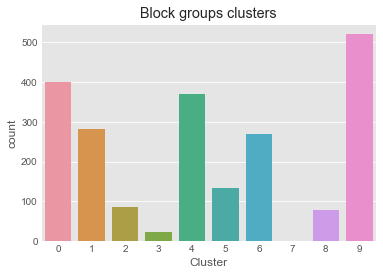

In [21]:
# plotting the clusters
sb.countplot(predictions);
plt.xlabel('Cluster');
plt.title('Block groups clusters');

In [22]:
# retreiving clusters features' centers
cluster_centers = scaler.inverse_transform(model_10.cluster_centers_)

In [23]:
# saving cluster centers as a dataframe
cluster_ids = ['Cluster_{}'.format(i) for i in range(1, cluster_centers.shape[0]+1)]
centers_df = pd.DataFrame(data=cluster_centers, columns=df_scaled.columns, index=cluster_ids)
centers_df

,income,kmdensity,distance
Cluster_1,25791.935162,170.553528,2.648003
Cluster_2,16964.651246,1925.649991,0.483526
Cluster_3,23958.827586,38.970273,9.884179
Cluster_4,10344.666667,12005.020468,0.135641
Cluster_5,36368.784367,544.351324,1.532028
Cluster_6,16638.488722,5637.601159,0.216121
Cluster_7,25863.133333,95.601676,5.450183
Cluster_8,2177.500000,33803.550780,0.495987
Cluster_9,53345.987179,715.346585,1.462470
Cluster_10,25979.038536,1018.243845,0.676433


In [24]:
# clusters of block groups with far agencies
centers_df[centers_df['distance'] >= 1]

,income,kmdensity,distance
Cluster_1,25791.935162,170.553528,2.648003
Cluster_3,23958.827586,38.970273,9.884179
Cluster_5,36368.784367,544.351324,1.532028
Cluster_7,25863.133333,95.601676,5.450183
Cluster_9,53345.987179,715.346585,1.462470


#### Interpreting the results
In the above cell: clusters with average distance greater than 1 mile are shown. Clusters 3 and 7 have the largest average distances (farthest agencies) and they are relatively low-income clusters. However, they are also less densely populated than the others. Cluster 1 is low-income; more populated than clusters 3 and 7; and has an average distance of 2.6 miles, which is considered far given that many people who benefit from the food bank do not have a car and have to walk to the food bank.

So, we can list the clusters according to their need for an agency (first has the most need):
    1. Cluster 1
    2. Cluster 7
    3. Cluster 3
    4. Cluster 5
    5. Cluster 9

### Mapping the under-served block groups
Ideally, I would use the library [Folium](https://python-visualization.github.io/folium/quickstart.html#Choropleth-maps) to create a choropleth map visualizing the clusters. However, the GeoJson data ended up being so large that folium couldn't handle well. Therefore, I am resorting to ArcGIS to create the map.

Below, I add the cluster labels to the block groups dataframe, and then write the resulting dataframe to a CSV file to use in ArcGIS

In [25]:
labels = pd.Series(predictions, index=block_groups.index)
block_groups['cluster'] = labels
block_groups.head()

,aland,awater,income,population,kmdensity,centx,centy,distance,cluster
geoid,,,,,,,,,
420130110012,23519032,13214,22944,846,35.970901,-78.498430,40.448109,1.935046,0
420130105001,27698847,29740,23042,715,25.813299,-78.439655,40.559719,3.316552,0
420130115002,18645960,0,19971,1269,68.057602,-78.467734,40.347121,2.352564,0
420130110022,3256834,0,32679,916,281.255005,-78.434047,40.463483,0.216430,4
420131016001,192907,0,11603,1131,5862.930176,-78.390637,40.514157,0.503062,5


In [26]:
block_groups.to_csv('block_groups_clusters.csv')

### Clusters Map
<img src="clusters_map.jpg" alt="A map showing locations of clusters" title="Clusters Map" width="450"/>